In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch import optim
import torch.nn.functional as F

cnn = models.resnet18(pretrained=False)
cnn.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

cnn.load_state_dict(torch.load("sensory_pretrained.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)

print(device)

cuda


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms

############################ Generators ##################################

def gen_sinusoid(sz, A, omega, rho):
    radius = int(sz / 2.0)
    [x, y] = torch.meshgrid([torch.tensor(range(-radius, radius)),
                             torch.tensor(range(-radius, radius))])
    x = x.float()
    y = y.float()
    stimuli = A * torch.cos(0.35 * omega[0] * x + 0.35 * omega[1] * y + rho)
    return stimuli.unsqueeze(0)  # Add channel dimension for grayscale

def gen_sinusoid_aperture(ratio, sz, A, omega, rho, polarity):
    sin_stimuli = gen_sinusoid(sz, A, omega, rho)
    radius = int(sz / 2.0)
    [x, y] = torch.meshgrid([torch.tensor(range(-radius, radius)),
                             torch.tensor(range(-radius, radius))])
    aperture = torch.empty(sin_stimuli.size(), dtype=torch.float)

    aperture_radius = float(radius) * ratio
    aperture[x ** 2 + y ** 2 >= aperture_radius ** 2] = 1 - polarity
    aperture[x ** 2 + y ** 2 < aperture_radius ** 2] = polarity

    return sin_stimuli * aperture

def sinusoid(theta):
    output = torch.zeros(1, 224, 224)
    sin_stim = gen_sinusoid(224, A=1, omega=[torch.cos(theta), torch.sin(theta)], rho=0)
    output[0, :, :] = sin_stim[0, :, :]
    return output

def sine_aperture(theta):
    sin_stim = gen_sinusoid_aperture(0.85, 224, A=1, omega=[torch.cos(theta), torch.sin(theta)], rho=0, polarity=1)
    return sin_stim.unsqueeze(0)  # Add batch dimension

#######################################################################

def get_response(torch_image, model, layer):
    """
    Gets the response of the network at a specified layer to a single image.
    Assumes the network is already on the appropriate device.
    """
    # Normalize the image using grayscale mean and std
    if torch.cuda.is_available():
        mean = torch.Tensor([0.485]).cuda()
        std = torch.Tensor([0.229]).cuda()
    else:
        mean = torch.Tensor([0.485])
        std = torch.Tensor([0.229])

    # Normalize image
    torch_image = (torch_image.to(mean.device) - mean) / std

    # Add batch dimension if necessary
    if len(torch_image.size()) == 3:  # E.g., (1, 224, 224) -> (1, 1, 224, 224)
        torch_image = torch_image.unsqueeze(0)

    # Hook to capture layer's output
    outputs_at_layer = []

    def hook(module, input, output):
        outputs_at_layer.append(output.detach())

    # Register hook on the chosen layer
    handle = list(model.children())[layer].register_forward_hook(hook)

    # Forward pass
    _ = model(torch_image)

    # Clean up hook and return output
    handle.remove()
    r = outputs_at_layer[0]
    del outputs_at_layer
    return r

def get_derivative(delta, plus_resp, minus_resp):
    """
    Calculates the finite-difference derivative of the network activation w/r/t angle.
    """
    deriv = (plus_resp - minus_resp) / (2 * delta)
    return deriv

def get_fisher(df_dtheta):
    """
    Compute Fisher information under Gaussian noise assumption.
    """
    fishers = 0
    for d in df_dtheta:
        fishers += torch.dot(d, d)
    fisher = fishers / len(df_dtheta)
    return fisher

def get_fisher_orientations(model, layer, n_angles=120, n_images=1, delta=1e-2, generator=None, device='cpu'):
    """
    Computes Fisher information with respect to orientation of the specified layer (averaged over sine grating phases).
    """
    phases = np.linspace(0, np.pi, n_images)
    angles = np.linspace(0, np.pi, n_angles)

    if generator is None:
        generator = lambda angle: sine_aperture(torch.tensor(angle))

    fishers_at_angle = []
    for angle in angles:
        all_phases_plus = torch.zeros(n_images, 1, 224, 224).to(device)
        all_phases_minus = torch.zeros(n_images, 1, 224, 224).to(device)

        for i, phase in enumerate(phases):
            all_phases_plus[i] = generator(angle + delta)
            all_phases_minus[i] = generator(angle - delta)

        # Get the response
        plus_resp = get_response(all_phases_plus, model, layer)
        minus_resp = get_response(all_phases_minus, model, layer)

        # Get derivative and compute Fisher information
        df_dtheta = get_derivative(delta, plus_resp, minus_resp)
        df_dtheta = df_dtheta.view(n_images, -1)
        fisher = get_fisher(df_dtheta)
        fishers_at_angle.append(fisher)

    return fishers_at_angle

In [19]:
def sinusoid(theta):
    """
    Generates a single-channel sinusoidal stimulus.
    """
    theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
    output = torch.zeros(1, 224, 224)  # Single-channel output
    sin_stim = gen_sinusoid(224, A=1, omega=[torch.cos(theta_tensor), torch.sin(theta_tensor)], rho=0)
    output[0, :, :] = sin_stim[0, :, :]
    return output

def sine_aperture(theta):
    """
    Generates a single-channel sine aperture stimulus.
    """
    theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
    sin_stim = gen_sinusoid_aperture(0.85, 224, A=1, omega=[torch.cos(theta_tensor), torch.sin(theta_tensor)], rho=0, polarity=1)
    return sin_stim.unsqueeze(0)  # Add batch dimension (1, 224, 224) for single-channel

def generator_gabor(angle, spatial_phase=None):
    """
    Generate a Gabor filter-based stimulus, ensuring single-channel output.
    """
    angle_tensor = torch.tensor(angle, dtype=torch.float32)  # Ensure angle is a torch tensor
    gabor = sinusoid(angle_tensor)  # Or replace with Gabor if needed
    return gabor  # Already a single-channel image


In [20]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import numpy as np


def plot_fisher(model, title, N=10, n_angles=40, n_phases=1, generator=None, scale=None, savefig=None):
    cs = sns.color_palette('plasma', N)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cs, len(cs))

    for i in tqdm(range(N)):
        sqrt_fishers_resnet = np.sqrt(torch.stack(get_fisher_orientations(model,i,n_angles, n_images=n_phases,
                                                              generator=generator_gabor, delta=1e-2)).cpu().numpy())
        normed =  sqrt_fishers_resnet/np.sum(sqrt_fishers_resnet)
        plt.plot(np.linspace(0, 180, n_angles),normed,"-", label = "Layer {}".format(i+1),c=cs[i])
    plt.ylim(bottom=0, top = max(max(normed),2*np.mean(normed)))
    # plt.ylabel(r"$\sqrt{J(\theta)}$ (normalized)", fontsize = 15)
    plt.ylabel("Sensitivity", fontsize = 15)
    plt.xlabel("Angle (º)", fontsize = 15)

    plt.xticks(np.linspace(0,180,5))
    #     plt.title("Layer {}".format(i), fontsize=15)
    #     plt.show()

    if scale is not None:
        plt.ylim(scale)

    plt.title(title, fontsize=20)
    # clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))
    # clb.ax.set_title('Layer')
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    
def shuffle_all_weights(model):
    """Note: this destroys the model. In-place"""
    for m in model.parameters():
        
        #look at Conv2d
        if len(m.data.size()) > 3:
            n_channels = m.data.size()[0]
            
            for row in range(m.data.size()[2]):
                for col in range(m.data.size()[3]):
                    
                    # make it so each 
                    idx = torch.randperm(n_channels)
                    m.data[:,:,row,col] = m.data[idx,:,row,col]
                    
        elif len(m.data.size()) == 2:
            m.data = m.data[torch.randperm(m.data.size(0))]
            m.data = m.data[:, torch.randperm(m.data.size(1))]
        elif len(m.data.size()) == 1:
            m.data = m.data[torch.randperm(m.data.size(0))]
        elif len(m.data.size()) == 3:
            m.data = m.data[torch.randperm(m.data.size(0))]
            m.data = m.data[:, torch.randperm(m.data.size(1))]
            m.data = m.data[:, :, torch.randperm(m.data.size(2))]
                    
        
                        
    return model
            


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1211209/1392661651.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


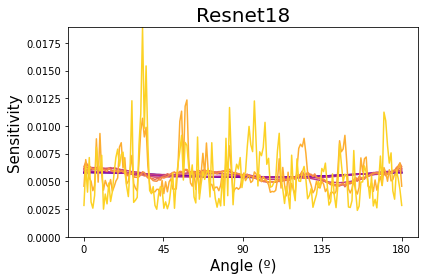

In [24]:
plot_fisher(cnn, "Resnet18", 10, n_angles=180, n_phases=1)

  0%|          | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_1211209/1392661651.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


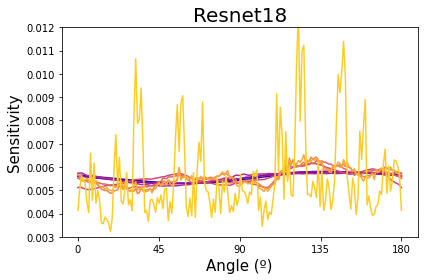

In [42]:
plot_fisher(cnn, "Resnet18", 9, n_angles=180, scale=(0.003,0.012), n_phases=1)

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_1478516/1392661651.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


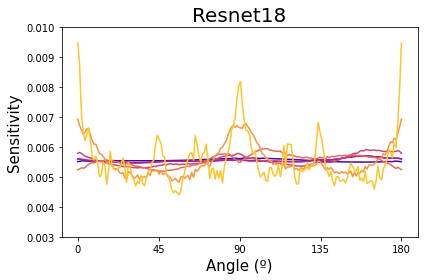

In [27]:
plot_fisher(cnn, "Resnet18", 7, n_angles=180, scale=(0.003,0.01), n_phases=1)

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_1211209/1392661651.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


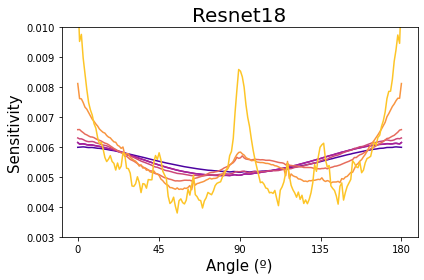

In [47]:
plot_fisher(cnn, "Resnet18", 7, n_angles=180, scale=(0.003,0.01), n_phases=1)